In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Modelselection, Overfitting and Underfitting

This task is intended to clarify the terms training set, validation set and test set and demonstrate how to identify the best performing model. Specifically, you extend a one-dimensional data series $x$ with polynomial base functions $[x^2, x^3, ..., x^k]$. Your task is to determine a suitable polynomial degree $k$.

Let's define a random data set:

In [2]:
x_max = 10      # our input ranges from -x_max to x_max, we get training examples from this 1D range
n_data = 80     # number of training examples 
max_k = 9       # highest degree of polynomial to consider

# the true (non-polynomial) function that we would like to learn
def true_process(x):
    # sin(x + 2) * (x - 1)
    return np.sin(x + 2) * (x - 1)
    
def gen_data_set():
    np.random.seed(1338)
    data_x = - x_max + np.random.rand(n_data) * (2 * x_max)
    data_y = true_process(data_x)
    noise = np.random.normal(0, 1.5, n_data)
    data_y += noise
    return (np.atleast_2d(data_x).T, data_y)

Text(0, 0.5, 'Labels')

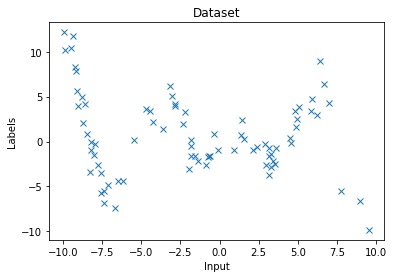

In [3]:
data_x, data_y = gen_data_set()

plot(data_x, data_y, 'x')
title('Dataset')
xlabel('Input')
ylabel('Labels')

## Training-Validation-Test Split
Now that we have our data set, we separate the data into a training set and a preliminary test set:


In [4]:
# first, we get a random number for every training example between 0 and 1
np.random.seed(1337)     # just to have everything reproducible
rand_numbers = np.random.rand(len(data_x))
print(rand_numbers)

[0.26202468 0.15868397 0.27812652 0.45931689 0.32100054 0.51839282
 0.26194293 0.97608528 0.73281455 0.11527423 0.38627507 0.62850118
 0.12505793 0.98354861 0.44322487 0.78955834 0.79411858 0.36126157
 0.41610394 0.58425813 0.76017177 0.18780841 0.28816715 0.67021886
 0.49964826 0.17856868 0.4131413  0.19919524 0.5316994  0.8323707
 0.18525095 0.95735922 0.42541467 0.50400704 0.51047095 0.01579145
 0.73169007 0.99330504 0.16287753 0.12663478 0.37483418 0.69321944
 0.00290103 0.36922906 0.05867933 0.78933609 0.34976921 0.70252372
 0.49122908 0.97287233 0.83596788 0.61023733 0.56451898 0.99738914
 0.25472414 0.01437786 0.08904507 0.9389826  0.9734594  0.49148153
 0.34093597 0.72285762 0.01089676 0.75995318 0.67140279 0.19044553
 0.66646465 0.9111224  0.16211743 0.91057832 0.3243579  0.70029842
 0.26545034 0.51895865 0.17746798 0.46784597 0.44896452 0.39606462
 0.79192543 0.49339824]


In [5]:
# then take the indices for all numbers < 0.70 as our training indices 
# afterwards, about 70% of all instances are in the training set
train_indices = rand_numbers < 0.70
print(train_indices)

[ True  True  True  True  True  True  True False False  True  True  True
  True False  True False False  True  True  True False  True  True  True
  True  True  True  True  True False  True False  True  True  True  True
 False False  True  True  True  True  True  True  True False  True False
  True False False  True  True False  True  True  True False False  True
  True False  True False  True  True  True False  True False  True False
  True  True  True  True  True  True False  True]


In [6]:
train_x = data_x[train_indices]
train_y = data_y[train_indices]

# the complementary part serves as preliminary test set 
test_x = data_x[~train_indices]
test_y = data_y[~train_indices]

print(train_x.shape)
print(test_x.shape)

(57, 1)
(23, 1)


Now we should also split the preliminary test set into a *validation set* (for model selection) and a "real" *test set* to realistically estimate the error.  

In [7]:
# Task a)

## TODO Use half of the test set as validation set and update the test set.
val_x = test_x
val_y = test_y


Let's first take only normal linear regression to have a starting point for the polynomial regression code:

In [8]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=True)
# performs linear regression on the inputs
reg.fit(train_x, train_y)

# if the resulting model is: y = w0 + w1 * x   then reg.intercept_ contains w0 and reg.coef_ contains w1 
# (reg.coef_ contains an array for the dimensions we will get)
w0, [w1] = reg.intercept_, reg.coef_
print('w0:', w0, ', w1:', w1)

w0: 0.6958543269865543 , w1: -0.11283745870969632


Text(0, 0.5, 'Target')

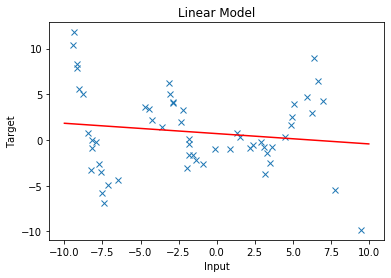

In [9]:
# let's plot the model in action
def predict(x, w0, w1):
    return w0 + w1 * x

# plot data set and linear model
plot_x = np.linspace(- x_max, x_max, 100)
plot(train_x, train_y, 'x')
plot(plot_x, predict(plot_x, w0, w1), 'r')
title('Linear Model')
xlabel('Input')
ylabel('Target')

## Polynomial Regression with Basis Extension

In order not to be able to perform "only" simple linear regression, we use the "trick" of the polynomial basic function extension. This means, instead of predicting based on $x$ only, we add $x^2$, $x^3$ etc. as new features.

Starting from the case $x \in \mathbb{R}^1$ (thus a scalar) with the model 
$$ y = w_0 + w_1 \cdot x $$

we extend for the complexity $k>1$ (the degree of polynomial) on vectors 
$\textbf{h}(x) = [x, x^2, \ldots, x^k]^T \in \mathbb{R}^k$ 

and then receive a model 
$$ y = w_0 + w_1 \cdot x_1 + \ldots + w_k \cdot x_k = w_0 + w_1 \cdot x + \ldots + x_k \cdot x^k 
= \textbf{w}^T \textbf{h}(x) + w_0 $$

with $k$ weights/ coefficients stored in $\textbf{w}$ (and scalar bias $w_0$), which is linear in the new features. 

Now the question arises which $k$ is best for our dataset. 

In [10]:
# Task b)

# now we iterate over our complexity values k and train linear regression models with the polynomial
# basis function expansions

for k in range(2, max_k + 1):
    print("Model complexity (polynomial degree) k =", k)
    
    ## TODO Perform basis function expansion on the training set.
    expanded_train_x = train_x
    
    reg.fit(expanded_train_x, train_y)
    
    ## TODO Calculate the loss (RMS error) on the training and validation set.
    train_error = 0.0
    val_error = 0.0
    print("Training error:", train_error)
    print("Validation error:", val_error)
    print("-----------------------------------------")
    

Model complexity (polynomial degree) k = 2
Training error: 0.0
Validation error: 0.0
-----------------------------------------
Model complexity (polynomial degree) k = 3
Training error: 0.0
Validation error: 0.0
-----------------------------------------
Model complexity (polynomial degree) k = 4
Training error: 0.0
Validation error: 0.0
-----------------------------------------
Model complexity (polynomial degree) k = 5
Training error: 0.0
Validation error: 0.0
-----------------------------------------
Model complexity (polynomial degree) k = 6
Training error: 0.0
Validation error: 0.0
-----------------------------------------
Model complexity (polynomial degree) k = 7
Training error: 0.0
Validation error: 0.0
-----------------------------------------
Model complexity (polynomial degree) k = 8
Training error: 0.0
Validation error: 0.0
-----------------------------------------
Model complexity (polynomial degree) k = 9
Training error: 0.0
Validation error: 0.0
--------------------------

## Analyse of Generalization 

Now we output a so-called *learning curve*, i.e. a plot with the complexity $k$ on the x-axis/absciss as well as the training and validation errors on the y-axis/ ordinate.

In [11]:
# Task c)

## TODO Plot the learning curve. 

## TODO Determine the best model complexity for the given data points. 

## Printing the Test Error
Finally, we compare the error of the best model on the validation set with the final error on the test set (never used before).

In [12]:
# Task d)

## TODO Calculate the loss for the best k on the validation and test set (=generalization error).
best_k_val_error = 0.0
best_k_test_error = 0.0

print("Validation error:", best_k_val_error)
print("Test error:", best_k_test_error)

## TODO Compare the validation and test error. What do you find?

Validation error: 0.0
Test error: 0.0
